In [1]:
import os 

import pandas as pd
import numpy as np
import scipy.stats
from sklearn.linear_model import LinearRegression
import sklearn.metrics

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import micplot
import readtop2000
import top2000analysis

In [2]:
FOLDER_OUTPUT = os.path.join('..', 'Output')
FOLDER_DATA = os.path.join('..', 'Data')

Recently, I published a [blog](https://sjoerdcornelissen.com/2021/03/02/the-effect-of-passing-away-on-top-2000-ranking/.) on the effect of passing away on rakings in the Top 2000. There, I dived deep into the outcomes of the model. Additionally, I also want to show how to build such a model and do the analysis, which I will do in this blog series.

I will do so in three parts:
1. *Part 1: Reading and understanding the data*  
  In this part, I will acquire the data and get a first feel for it.
1. *Part 2: Building and checking a hierarchical Bayesian regresson model*  
In this part, I will use the data and knowledge about it we acquired in the first part to actually build a hierachical, Bayesian model. Part of building a Bayesian model is also checking whether it works as expected.
1. *Part 3: Using the model for inference and prediction*  
  In the final part, I will show how to use the model to get the insights we want.

# Reading and understanding the Top 2000 data 

No data science without data. While it is often the least sexy part, acquiring, structuring and importantly understanding the data well will set a project up for success, while skimping this might look good in the short term, but always turns out to hit you hard much quicker than expected, when weird results keep popping up and find out whether this is a problem with the data, the code or there is actually something interesting going up turns into an almost impossible task.

In this part, we will do three things:
1. _Acquiring the data_  
We scrape wikipedia for everything about the Top 2000
1. _Structuring the data_  
By putting the data into tables that are structured through a data model, we keep all the flexibility for future analyses.
1. _Understanding the data_  
By looking into the univariate relations, we get a feeling for what influences what, which will help us when building a model.

In terms of the business case, we learn that 
* The boost, or increase in ranking, of a song after the passing of an artist is almost always there, but the size of the boost is highly variable
* It makes sense to look at the _logarithm_ of the boost, and it can be explained by hypotheses on three levels: the Base Level, the Artist level (which is the most important) and the Song level
* Popularity-related measures should be transformed to a logarithm, while the recency component should be modeled as an exponential.

## Acquiring the data: scraping wikipedia with a custom `wikipediareader`
First, we scrape the rankings from for each Top 2000 in history from [Wikipedia](https://nl.wikipedia.org/wiki/Lijst_van_Radio_2-Top_2000%27s). While NPO Radio 2, the organizer, also publishes the list in Excel form on the [Top 2000 website](https://www.nporadio2.nl/top2000), I did not use that for two reasons:
* It uses an inconsistent format through the years, both in column names and band names.
* For the more detailed artist information I need, such as date of birth and date of death, I would have to use an external source anyway, so it is easier to immediately use Wikipedia. We can use the links in the full list to immediately go to the right artist and song.

While there are libraries that access Wikipedia in python, such as [`wikipedia`](https://pypi.org/project/wikipedia/) and [`Wikipedia-API`](https://pypi.org/project/Wikipedia-API/), I did not use those:
* They are generally oriented towards a user-oriented way of looking through Wikipidia, with a user searching and reading the main text. I, on the other hand, am focused on extracting the Tables and Infoboxes, and there was no good support for that. 
* The link(s) that are in the cells are important, since we will want to browse those for more detailed information. This generally does not come out of the box.

Therefore, I decided to write a very quick module that reads Tables and Infoboxes from Wikipedia. It can be found on my Github as [`wikipediareader`](https://github.com/SjoerdCor/Top2000/blob/main/src/wikipediareader.py).

This module is used by the `readtop2000` module, which reads and then writes the information we need about the Top2000
1. Scrapes the full list (https://nl.wikipedia.org/wiki/Lijst_van_Radio_2-Top_2000%27s)
1. Goes to all artist pages it finds on the full list and adds the information from the Infobox on that page to the table
1. Cleans the column names and types and validates the reading worked
1. Writes the information to a structured data model.

We store all the tables as _.parquet_-files, a commonly used format that also store data types and is memory and time efficient.

## Structuring the data
### Splitting data into a data model
By thinking about how we should structure and save the data, we save ourselves from a lot of pain down the road. I decided to save the information according to the following data model:

<img src="../blogfigures/Reading and understanding Top 2000 data/datamodel.PNG" title="The data model consists of ranking table with a many-to-one relationship to song, which has a one to many relationship to songartist, which has a many-to-one relationship with artist"/>
We have the following entities:

* A **ranking** for each song for each year in the Top 2000
* A **song** which is performed by one or more artists
* An **artist** who performs one or more songs.

The most notable as aspect is that **song** and **artist** have a [many-to-many relationship](https://en.wikipedia.org/wiki/Many-to-many_(data_model)), so we add a junction table between those. The artist table contains a column for every label that is used on at least one artist on Wikipedia, so it has a lot columns and a lot of `NaN`s.


Finally, we have to add one bit of information: the **VotingPeriod**. The recency of the death is important, I hypothesize, so I need to know how long before the voting period somebody passed away. Unfortunately, I could not find a comprehensive source for this, so I collected this data manually by googling a lot and looking for old news itmes covering the Top 2000.

Now that we have read and structured all the data, we can finally get the data. It takes 10 to 15 minutes on my computer to scrape Wikipedia.

In [3]:
# This takes a bit of time and only needs to be done once, so I commented it out. Comment to download the newest files
# downloader = readtop2000.Top2000Downloader()
# downloader.download_and_write(FOLDER_OUTPUT)

### Recombining and selecting the data
Now, we wish to get a table on which we can perform the analysis. For this, we combine all data, with one row for each artist for each song, so a song which is a duet occurs twice. 

In [4]:
a = top2000analysis.AnalysisSetCreator(FOLDER_DATA)

df_full = a.combine_data()
print(f"In its history, the Top 2000 has seen {df_full['SongID'].nunique()} unique songs and {df_full['ArtistID'].nunique()} unique artists")

In its history, the Top 2000 has seen 4573 unique songs and 1979 unique artists


For this analysis, I only select the rows of the years in which the artist passed away, and add the information of the year before, so I can compare the number of votes.

I also calculate the percentage of the vote each song received every year based on a model from [Peter Meindertsma](https://www.petermeindertsma.nl/blog/benadering-aantal-stemmen-per-liedje-in-de-top-2000-van-2014/). We end up with the dataframe as shown below, which contains all the information we need to perform the analysis.

In [5]:
df_artist = a.create_artist_set()

In [6]:
df = a.create_full_feature_set()

In [7]:
with pd.option_context('display.max_columns', None):
    display(df.sample(5, random_state=123))

,SongID,Year,Rank,Title,YearMade,LinkSong,ArtistID,LinkArtist,Act(s),Afleveringen,Alias,Bedenker,Bekend van,Bekendste werk,Belangrijkste werken,Beroep,Beroep(en),Bezetting,Bijnaam,Boek,Budget,Choreografie,Cinematografie,Distributie,Einde,Ensemble(s),Gebaseerd op,Geboorteland,Geboortenaam,Geboorteplaats,Geboren,Genre,Genre(s),Handtekening,Hoofdrollen,Instrument,Instrument(en),Intromuziek,Invloed(en),Jaren actief,Jaren actief,Laatste voorstelling,Label(s),Land,Manager,Medium,Montage,Muziek,Nationaliteit,Netwerk of omroep,Nevenberoep,Ook bekend als,Oorsprong,Opbrengst,Opgegroeid te,Overige nominaties,Overleden,Overlijdensplaats,Platenlabel,Première,Producent,Pseudoniem,Pseudoniem(en),Regie,Regisseur,Scenario,Speelduur,Start,Stijl,Taal,Teksten,Verwante artiesten,Verwante acts,Volledige naam,Volledige naam,Zangstem,Zender,DateOfBirth,HasPassed,DateEndOfVoting,PassingTooEarly,PctVotesAfterDeathSong,NrArtists,MultiplePerformers,YearsSinceOverlijden,PopularityWithinArtist,LogSongPopularityWithinArtist,RecencyWithinArtist,RankLastYear,PctVotesBeforeDeathSong,BoostSong,LogBoostSong,YearsBeforeDeath,JarenGeleden,PctVotesAfterDeathArtist,PctVotesBeforeDeathArtist,LastSongYearInTop2000,NSongsBeforeDeath,Name,IsDutch,AgePassing,Top2000YearOfDeath,DateOfDeath,DaysToEndOfVoting,LogPopularity,LogPopularityNorm,BoostArtist,LogBoostArtist,YearsSinceLastHit,SongRelativeBoost,LogRelativeBoost,LogBoost
1629,5043495918341841575,2001,161.0,Saturday night,1978,https://nl.wikipedia.org/wiki/Saturday_night_(...,8228541565564833236,https://nl.wikipedia.org/wiki/Herman_Brood,"The Moans, Cuby and the Blizzards, Wild Romanc...",None,None,None,None,None,None,"Musicus, kunstschilder, acteur en dichter",None,None,Rock 'n' roll junkie,None,None,None,None,None,None,None,None,None,None,Zwolle,5 november 1946,None,"Rock-'n-roll, jazz, blues",None,None,None,"Piano, vocals",None,None,1964-2001,None,None,None,Nederland,None,None,None,None,None,None,None,None,None,None,None,None,11 juli 2001 te Amsterdam,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"Long Tall Ernie and the Shakers, Stud, Jan Akk...",None,None,Hermanus Brood,None,None,1946-11-05,True,2001-12-01,25.319644,0.001136,2,1,0.0,1.571590,0.196339,0.000000,419.0,0.000482,2.357895,0.857769,-23.0,-19.0,0.001446,0.000684,1979,2,Herman Brood,1,54.680356,2001.0,2001-07-11,-143.0,-3.164861,0.376883,2.113914,0.748541,22.0,1.115417,0.109228,0.857769
6806,-7574359214856386571,2003,782.0,"Ain't Got No, I Got Life",1968,"https://nl.wikipedia.org/wiki/Ain%27t_Got_No,_...",5666325769293300336,https://nl.wikipedia.org/wiki/Nina_Simone,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,21 februari 1933,None,"Blues, Folk, Gospel, Jazz, Rhythm-and-blues, Soul",None,None,None,None,None,None,1954-2003,None,None,"Bethlehem Records, Colpix Records, Legacy Reco...",Verenigde Staten,None,None,None,None,None,None,None,None,None,None,None,None,21 april 2003,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Eunice Kathleen Waymon,None,None,1933-02-21,True,2003-12-15,9.839836,0.000266,1,0,0.0,1.468431,0.166854,0.173913,988.0,0.000212,1.254007,0.226344,-35.0,-17.0,0.000431,0.000343,1987,2,Nina Simone,0,70.160164,2003.0,2003-04-21,-238.0,-3.464090,0.077653,1.254589,0.226808,16.0,0.999536,-0.000464,0.226344
20070,-3904354950974530796,2006,1598.0,Twenty Four Hours from Tulsa,1964,https://nl.wikipedia.org/wiki/Twenty_Four_Hour...,-1086948975686417956,https://nl.wikipedia.org/wiki/Gene_Pitney,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,17 februari 1941,None,None,None,None,None,None,None,None,None,None,None,None,Verenigde Staten,None,None,None,None,None,None,None,None,None,None,None,None,5 april 2006,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1941-02-17,True,2006-12-01,14.872005,0.000133,1,0,0.0,0.953698,-0

In [8]:
print(f'The final data contains {len(df)} rows, which means there are {len(df)} songs which were in the Top 2000 the year before the artist passed away.')
print(f'They come from {df["ArtistID"].nunique()} unique artists')

The final data contains 154 rows, which means there are 154 songs which were in the Top 2000 the year before the artist passed away.
They come from 63 unique artists


## Basic data inspection
With the data in hand, it is always tempting to immediately go to the _cool_ stuff, but it is paramount to stay in control, by first making the quick graphs to understand what's happening on a basic level.

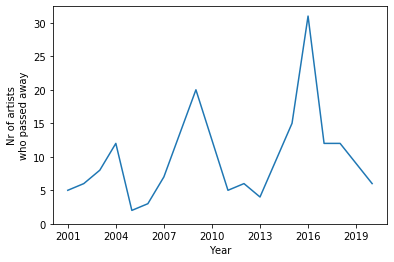

In [9]:
ax = df['Year'].value_counts().sort_index().plot(ylim=(0, None), xlabel='Year', ylabel='Nr of artists\nwho passed away')
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.show()

We see a number of artists passing awayt each year, with a spike in 2016.

Next, let's see what happened to the ranking of each song.

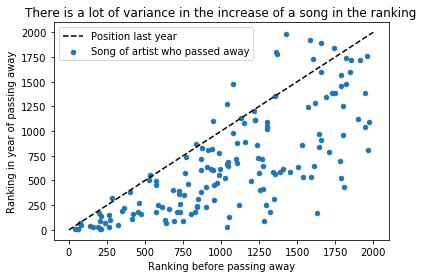

In [10]:
ax = df.plot(kind='scatter', x='RankLastYear', y='Rank', label='Song of artist who passed away', title='There is a lot of variance in the increase of a song in the ranking')
ax.plot([0, 2000], [0, 2000], 'k--', label='Position last year')
ax.set_xlabel('Ranking before passing away')
ax.set_ylabel('Ranking in year of passing away')
plt.legend()
plt.show()

Since most dots are below the dashed line, indeed almost all songs (but notably not all) receive some sort of boost in the year the artist passed away. We also see there are huge differences in the size of the effect: with some songs ranking below 1500 entering the Top 250 a year later, while some Top 500 songs stay right where they are. This learns us that we really need a model that has access to relevant attributes to make an accurate inference about what drives the boost.

For the analysis, the discrete nature of rankings is a problem; the difference between songs ranked 2000 and 1980 is very different from the songs ranked 21st and first. Therefore, we estimate the number of votes through a model developed by [Peter Meindertsma](https://www.petermeindertsma.nl/blog/benadering-aantal-stemmen-per-liedje-in-de-top-2000-van-2014/).

Furthermore, we define a _Boost_  as the ratio between the percentage of votes of the song in the year of the artist passing away and the percentage of the vote of that song in the year before.

### Inspection of the boost distribution

In [11]:
def plot_distribution(series, dist='norm', **kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    series.plot(kind='kde', ax=axes[0], **kwargs)
    scipy.stats.probplot(series, dist=dist, plot=axes[1])
    plt.tight_layout()
    plt.show()
    display(series.describe())

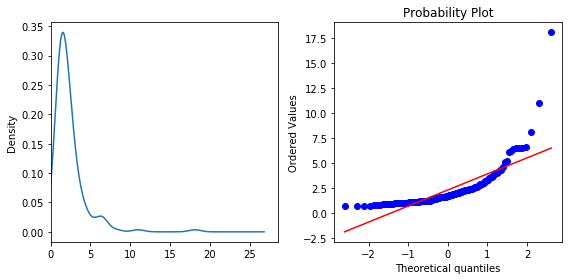

count    154.000000
mean       2.329310
std        2.032922
min        0.723932
25%        1.225985
50%        1.746682
75%        2.573768
max       18.101695
Name: BoostSong, dtype: float64

In [12]:
plot_distribution(df['BoostSong'], xlim=(0, None))

We see the average song gets a boost of 2.3x as many votes as the year before, and the median is 1.75x as many votes. Notably, the Boost distrution is not Normal. Therefore, we also inspect the logarithm of the boost:

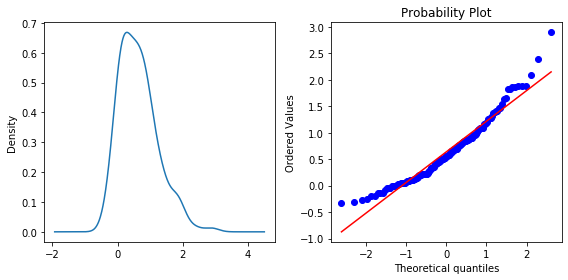

count    154.000000
mean       0.639072
std        0.587884
min       -0.323057
25%        0.203744
50%        0.557716
75%        0.945259
max        2.896006
Name: LogBoost, dtype: float64

In [13]:
plot_distribution(df['LogBoost'])

Still not perfectly normal, but at least it's closer. In our further estimation, we will often work with the logarithm, because the regular boost is dominated by a few outliers.

Next, we will also investigate the _artist boost_, defined as the the total number of votes for an artist in the year of his death divided by the total number of votes in the year before, instead of each song individually

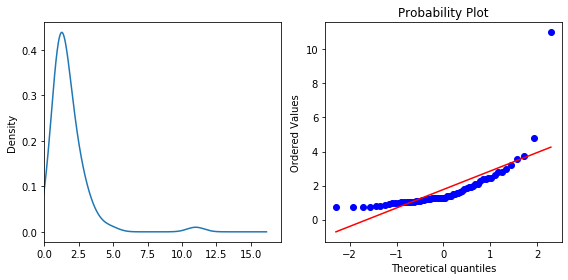

count    63.000000
mean      1.772027
std       1.437898
min       0.723932
25%       1.053936
50%       1.268907
75%       2.038679
max      10.991597
Name: Boost, dtype: float64

In [14]:
plot_distribution(df_artist['Boost'], xlim=(0, None))

Again, we see the same distribution. Notably, the average _artist_ boost is lower than the average _song_ boost. This can be explained if artists with multiple songs on average see a larger boost. We make the same plot, but now binned for easier interpretation, to show in the blog. 

Indeed, most artists get a boost, and it is often between 50% and 150%.

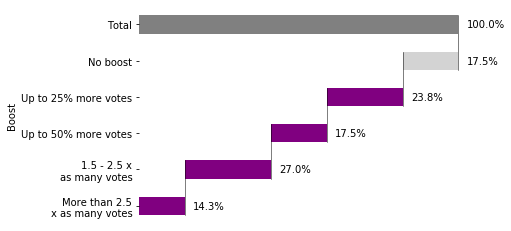

In [15]:
data = pd.cut(df_artist['Boost'], [0, 1, 1.25, 1.5, 2.5, np.inf],
               labels=['No boost',
                       'Up to 25% more votes',
                       'Up to 50% more votes',
                       '1.5 - 2.5 x\nas many votes',
                       'More than 2.5\nx as many votes']).value_counts(normalize=True).sort_index(ascending=False)
data.index = data.index.astype(str) # Otherwise, can not add row for Total
micplot.visualize(data, highlight=range(4), sorting='original')
plt.show()

Now, let's check who got the smallest and largest boosts.

In [16]:
from IPython.display import display_html
relevant_columns = ['Name',
                   'Boost',
                   'LogPopularityNorm',
                   'NSongsBeforeDeath',
                   'DateOfDeath']

df_smallest_boosts = df_artist.query('Boost < 1')[relevant_columns].sort_values('Boost').set_index('Name')
df_largest_boosts = df_artist.nlargest(10, 'Boost')[relevant_columns].set_index('Name')

df1_styler = df_smallest_boosts.style.format({"DateOfDeath": '{:%Y-%b-%d}'}).set_table_attributes("style='display:inline'").set_caption('Artist with smallest boosts')
df2_styler = df_largest_boosts.style.format({"DateOfDeath": '{:%Y-%b-%d}'}).set_table_attributes("style='display:inline'").set_caption('Artist with largest boosts')
display_html(df1_styler._repr_html_() +  ' ' + df2_styler._repr_html_(), raw=True)  # Display side by side

,Boost,LogPopularityNorm,NSongsBeforeDeath,DateOfDeath
Name,,,,
Tol Hansse,0.723932,-0.287725,1,2002-Apr-29
Timi Yuro,0.735862,-0.167722,1,2004-Mar-30
Conny Vandenbos,0.759279,-0.267294,1,2002-Apr-07
David McWilliams,0.771998,-0.268541,1,2002-Jan-08
Long John Baldry,0.822581,-0.153757,1,2005-Jul-21
Charles & Eddie,0.828880,-0.331602,1,2001-Apr-06
Syreeta,0.878519,-0.350567,1,2004-Jul-05
Ray Charles,0.922737,0.117318,2,2004-Jun-10
Benny Neyman,0.962199,0.127845,1,2008-Feb-07


# Univariate analysis
We understand the data set and have a basic feeling for the data, but before we dive into a complex multivariate model, it is wise to go step by by step. In our case, that means first doing a univariate analysis of the hypotheses.

Therefore, we must formulate hypotheses on what affects the size of the boost on three levels:
1. A __base__ effect for every artist
1. An __artist specific__ effect, based on the characteristics of the artist and his/her death - aspects that have to do with how prominent the artist will be in the news after his/her death
1. A __song specific__ effect, for which songs channel the newfound votes.

For each step, the hypotheses are shown in the table below:

<img src="../blogfigures/Reading and understanding Top 2000 data/Hypothesis.png" alt="Hypotheses are formulated for each level, to predict the boost of a song" width="750"/>


## The artist level is more important than the song level, but both are necessary to explain a boost
Before we dive in, lets check the relative importance of the levels. For this, we look into songs by artists who have multiple songs ranked in the Top 2000, which is ~80%.

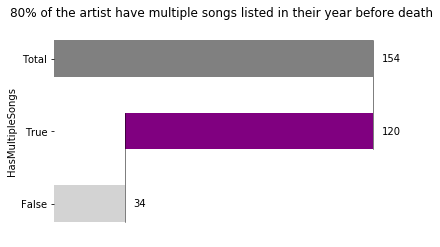

In [17]:
vis = (df.assign(HasMultipleSongs = lambda df: df['NSongsBeforeDeath'].ge(2))
         .groupby('HasMultipleSongs').size()
         .pipe(micplot.visualize, plottype='waterfall')
        )
vis.ax.set_title('80% of the artist have multiple songs listed in their year before death')
plt.show()

I look into the relative importance of the levels by calculating the explained variance of the Logarithm of the Song Boost of the Artist on the one hand, and the Relative Song effect of the song (which is the Song Boost divided by the Artist Boost) on the other hand.

*SongBoost = ArtistBoost * RelativeSongBoost*

Taking the logarithms of both sides, we see they add up to the Log of the Boost, so

*LogSongBoost = LogArtistBoost + LogRelativeSongBoost*

Now, I calculate the ExplainedVariance of each of the two components. I find the Artist effect is 1.5x more important than the Relative Song effect. This ties in with the idea that people want to honour an artist who passed away, not a song they wrote. On the other hand, it does show both levels are important and we should definitely try to model both

The explained variance doesn't exactly add up to 100% because the two components are (very weakly) correlated.

In [18]:
df_multiple_songs = df.query('NSongsBeforeDeath >= 2').assign(LogBoostArtist = lambda df: np.log(df['BoostArtist']))

variance_explained_artist = sklearn.metrics.explained_variance_score(df_multiple_songs['LogBoost'], df_multiple_songs['LogBoostArtist'])
variance_explained_song = sklearn.metrics.explained_variance_score(df_multiple_songs['LogBoost'], df_multiple_songs['LogRelativeBoost'])
explained_variance = {'Artist': variance_explained_artist, 
                      'Song': variance_explained_song,
                      'Correlation': 1 - variance_explained_artist - variance_explained_song
                     }

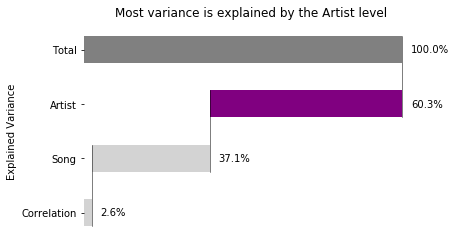

In [19]:
vis = (pd.Series(explained_variance, name='Explained Variance').pipe(micplot.visualize))
vis.ax.set_title('Most variance is explained by the Artist level')
plt.show()

The artist is most important, but we also see there is definetly still a lot of variance within the songs of an artist, which we should try to model.

In [20]:
def plot_with_trend(df, column, logy=False):
    ycolname = 'LogBoost' if logy else 'Boost'
    preds = LinearRegression().fit(df[[column]], df[ycolname]).predict(df[[column]])
    ax = df.plot(x=column, y=ycolname, kind='scatter', label='Passed away artists', c='grey')
    ax.plot(df[column], preds, 'k', label='Trend')
    ax.legend()
    return ax

## Base level
### Year
We hypothesize the boost has grown stronger over the years, because of more prevalent news, and indeed, we see this effect.

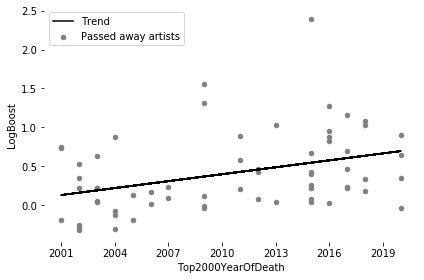

In [21]:
ax = plot_with_trend(df_artist, 'Top2000YearOfDeath', logy=True)
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
ax.set_frame_on(False)

## Artist level

### Popularity
When more popular artists die, they get much more news coverage: a relatively unknown artist may get a small article on page 15, while superstars may get entire TV shows devoted to hem. This in turn would result in much more prominent boosts for more popular artists

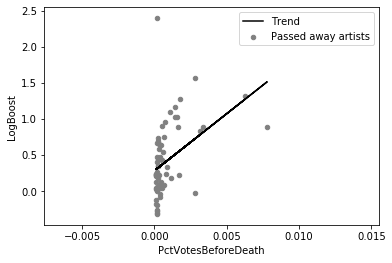

In [22]:
ax = plot_with_trend(df_artist, 'PctVotesBeforeDeath', logy=True)

This seems to be the case, but the effect between the _logarithm_  of the boost and the percentage of the votes is clearly non-linear, and the trendline is dominated by a few superstars. Let's look into the logarith of the percentage of votes

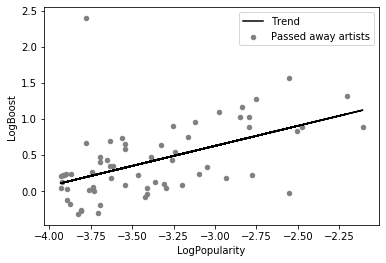

In [23]:
plot_with_trend(df_artist, 'LogPopularity', logy=True)

This looks much better: there is a strong, mostly linear relation between the logarith of the boost and the logarithm of the popularity.

### Nationality
We hypothesize Dutch voters care more about Dutch artists, out of chauvinism. The effect is hard to detect, since only a small number of Dutch artists passed away

In [24]:
print(f'{df_artist["IsDutch"].sum()} Dutch artists passed away')

11 Dutch artists passed away


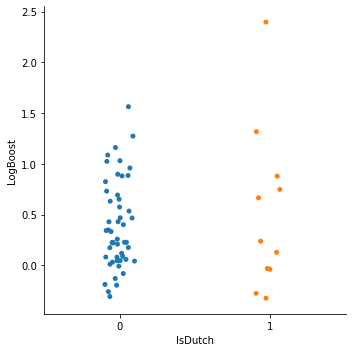

In [25]:
_ = sns.catplot(x='IsDutch', y='LogBoost', data=df_artist)

### Artist age
Newsworthiness of the death of an artist depends on the circumstances. Specifically, artists dying young is something that attracts a lot of media attention. This happens a lot in our sample:

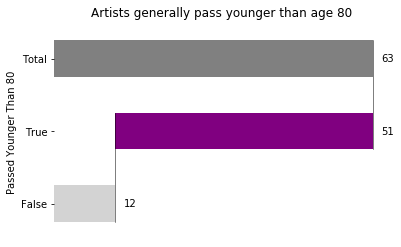

In [26]:
vis = (df_artist.groupby(df_artist['AgePassing'].lt(80)).size()
      .rename('Passed Younger Than 80')
      .pipe(micplot.visualize, plottype='waterfall')
    )
vis.ax.set_title('Artists generally pass younger than age 80')
plt.show()

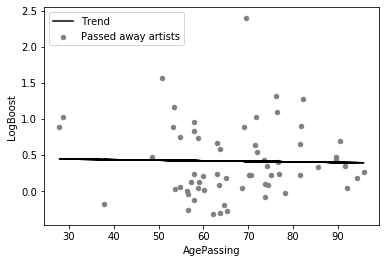

In [27]:
ax = plot_with_trend(df_artist, 'AgePassing', logy=True)

We do not see a strong _univariate_ effect, but this may be because of collinearity with other effects

### Recency
We hypothesize that the more top of mind a death is, the more of a boost an artist can expect - so more recent deaths during the time of voting should get a larger boost

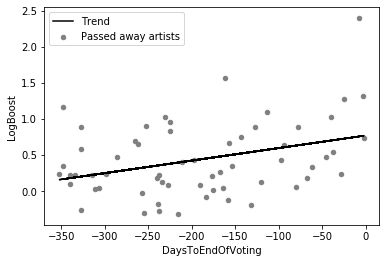

In [28]:
ax = plot_with_trend(df_artist.query('DaysToEndOfVoting > -365'), 'DaysToEndOfVoting', logy=True)

Indeed, this is the case; however, it is not entirely clear if this is a linear relationship. Lets bucket the observations to see that clearer

In [29]:
recency_buckets = (pd.cut(df_artist['DaysToEndOfVoting'].clip(lower=-365), 6, labels=False, retbins=False, right=False)
                  .map({i: v for i, v in enumerate(range(-333, 0, 60))}))

In [30]:
df_artist.groupby(recency_buckets)['LogBoost'].agg(['mean', 'sem', 'std', 'count'])

,mean,sem,std,count
DaysToEndOfVoting,,,,
-333,0.251792,0.095406,0.369506,15
-273,0.371306,0.162587,0.430165,7
-213,0.273213,0.123117,0.443904,13
-153,0.360391,0.149835,0.519044,12
-93,0.483057,0.150656,0.398597,7
-33,0.923017,0.226280,0.678839,9


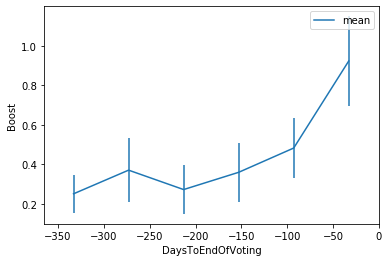

In [31]:
ax = df_artist.groupby(recency_buckets)['LogBoost'].agg(['mean', 'sem', 'std', 'count']).plot(y='mean', yerr='sem')
ax.set_ylabel('Boost')
plt.xlim(-365, 0)
plt.show()

There appears to be little difference out to ~ 150 days, and then the boost grows much stronger. We conclude we should allow for an exponential effect in the model.

### Correlations

To get a feeling for whether multicollinearity may be influencing our results, we quickly look at the correlations between the artist properties. We find that, probably mostly by coincidence, in recent years artists in the Top 2000 have tended to pass away at later ages, which may partly explain why we do not see a strong age effect in a univariate distribution. Furthermore, we see that in recent years more popular artists have tended to pass away.

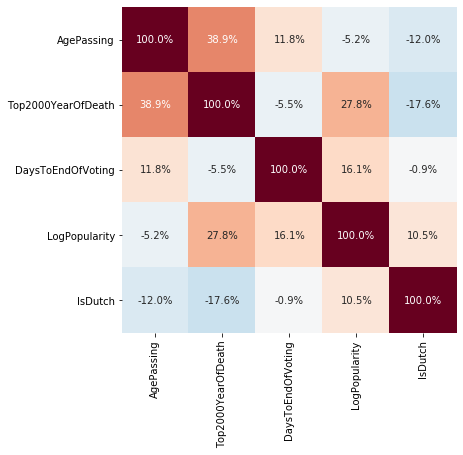

In [32]:
def plot_correlations(df, figsize=(12, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df.corr(), cmap='RdBu_r', vmin=-0.8, vmax=0.8, annot=True, fmt='.1%', ax=ax, cbar=False)
    return ax

plot_correlations(df_artist[['AgePassing', 'Top2000YearOfDeath', 'DaysToEndOfVoting', 'LogPopularity', 'IsDutch']], figsize=(6, 6))

## Song

### Popularity within artist oeuvre

In the [literature](https://link.springer.com/article/10.1007/s11002-014-9322-1) there is some work that shows more popular albums get larger boosts.

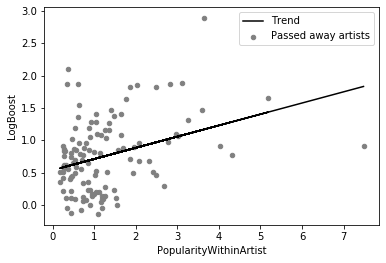

In [33]:
ax = plot_with_trend(df_multiple_songs, 'PopularityWithinArtist', logy=True)

Again, we are dominated by a few outliers

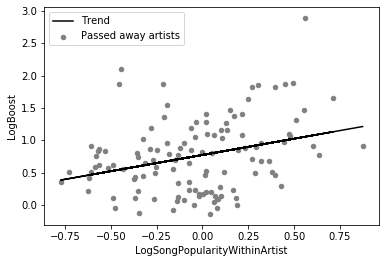

In [34]:
ax = plot_with_trend(df_multiple_songs, 'LogSongPopularityWithinArtist', logy=True)

So, it appears this is true in our case as well: more popular songs get larger boosts.

### Solo song
We hypothesize that solo songs get more of a boost than duets

In [35]:
df.groupby(['NrArtists'])['LogBoost'].agg(['mean', 'std', 'sem', 'count'])

,mean,std,sem,count
NrArtists,,,,
1,0.653842,0.606413,0.052583,133
2,0.587057,0.447788,0.105545,18
3,0.357387,0.689679,0.487677,2
5,0.174300,NaN,NaN,1


Let's group all non-solo songs together, since there are only 3 of those.

,mean,std,sem,count
MultiplePerformers,,,,
0,0.653842,0.606413,0.052583,133
1,0.545529,0.454095,0.099092,21


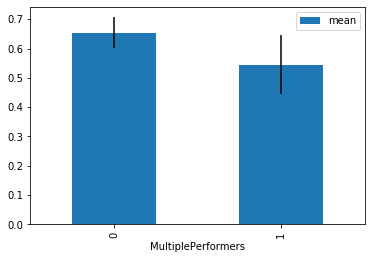

In [36]:
display(df.groupby(['MultiplePerformers'])['LogBoost'].agg(['mean', 'std', 'sem', 'count']))
(df.groupby(['MultiplePerformers'])
 ['LogBoost'].agg(['mean', 'std', 'sem', 'count'])
 .plot(y='mean', yerr='sem',
       xlim=(-0.5, 1.5), kind='bar')
)

There are not a lot of duets, but there is a hint they may indeed have a smaller boost

# Conclusions
* The data was scraped from Wikipedia, and then saved into parquet files according to a data model that makes it easy to recombine the data 
* It makes sense to look at the _logarithm_ of the boost, and we can explain it by hypotheses on three levels: the Base Level, the Artist level (which is the most important) and the Song level
* Popularity-related measures should be transformed to a logarithm, while the recency component should be modeled as an exponential.